In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
sys.path.append('..')
from src.models.model import VSpyct, Spyct
from src.data.dataset import ReducedDataset

/Users/viktorandonovic/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import pyro

In [4]:
path = os.path.join(os.getcwd(), '../data/raw')
filename = 'BO_truncated_mso_2018.pcl'
data = ReducedDataset(path, filename)
X_train, X_test, y_train, y_test = data.get_tensors()

(1984, 96) torch.Size([1984, 364])


In [5]:
bayes_spyct = VSpyct(bs=64, max_depth=3, epochs=200, lr=0.0001, minimum_examples_to_split=3)
bayes_spyct.fit(X_train, y_train)

Total variance: 50.10905456542969
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)


Epochs:  97%|█████████▋| 194/200 [00:56<00:01,  3.46it/s]


Early stopping at epoch 194.
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)
Rows left:  torch.Size([1164]) Var left tensor(44.8704)
Rows right:  torch.Size([820]) Var right tensor(56.3907)
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)


Epochs:  16%|█▋        | 33/200 [00:04<00:20,  8.02it/s]


Early stopping at epoch 33.
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)
Rows left:  torch.Size([552]) Var left tensor(55.0651)
Rows right:  torch.Size([268]) Var right tensor(58.9833)
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)


Epochs:  11%|█         | 22/200 [00:01<00:08, 20.23it/s]


Early stopping at epoch 22.
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)
Rows left:  torch.Size([50]) Var left tensor(61.6337)
Rows right:  torch.Size([218]) Var right tensor(58.0076)
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)


Epochs:   6%|▌         | 11/200 [00:01<00:17, 10.80it/s]


Early stopping at epoch 11.
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)
Rows left:  torch.Size([157]) Var left tensor(63.9514)
Rows right:  torch.Size([395]) Var right tensor(50.6340)
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)


Epochs:  92%|█████████▏| 183/200 [00:32<00:02,  5.72it/s]


Early stopping at epoch 183.
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)
Rows left:  torch.Size([335]) Var left tensor(55.0510)
Rows right:  torch.Size([829]) Var right tensor(37.9061)
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)


Epochs:  63%|██████▎   | 126/200 [00:15<00:08,  8.29it/s]


Early stopping at epoch 126.
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)
Rows left:  torch.Size([183]) Var left tensor(34.9852)
Rows right:  torch.Size([646]) Var right tensor(38.6324)
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)


Epochs:   6%|▌         | 12/200 [00:00<00:11, 17.05it/s]

Early stopping at epoch 12.
Impurity(
  (linear): PyroLinear(in_features=96, out_features=1, bias=True)
)
Rows left:  torch.Size([7]) Var left tensor(27.1905)
Rows right:  torch.Size([328]) Var right tensor(55.4299)


In [6]:
preds_bayes = bayes_spyct.predict(X_test)

In [7]:
preds_bayes_mean = preds_bayes.mean(axis=1)

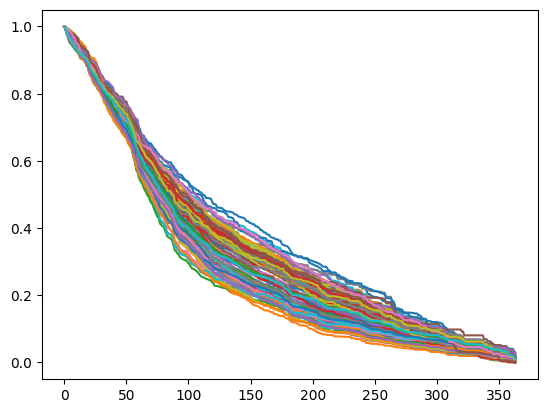

In [8]:
import matplotlib.pyplot as plt

for i in range(100):
  plt.plot(preds_bayes_mean[i,:]);

In [9]:
# from src.eval import IPCWBrier

# _bs_ = IPCWBrier(T_test, E_test)
# bs_vspyct = _bs_.evaluate(y_test, avg_preds)
# plt.plot(bs_vspyct)

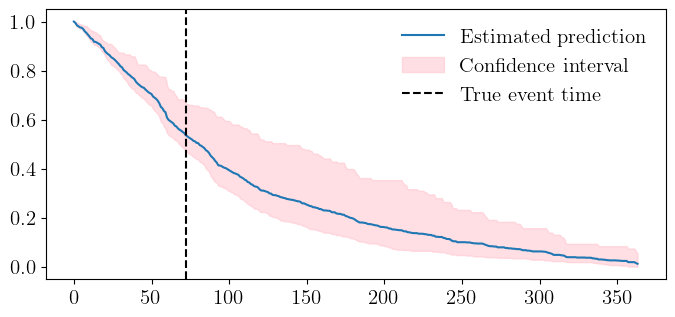

In [112]:
import matplotlib.pyplot as plt
i = 32

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
fig, ax = plt.subplots(figsize=(8,3.5))

ax.plot(preds_bayes[i, :, :].mean(axis=0), label='Estimated prediction')

percentiles_10 = torch.quantile(preds_bayes[i, :, :], 0.1, axis=0)
percentiles_90 = torch.quantile(preds_bayes[i, :, :], 0.9, axis=0)

# Plot the shaded area between the 10th and 90th percentiles
plt.fill_between(range(preds_bayes.shape[-1]), percentiles_10, percentiles_90, color='pink', alpha=0.5, label = 'Confidence interval')
plt.axvline(sum(y_test[i].numpy()), color='black', linestyle='--', label='True event time')

plt.legend(frameon=False)
plt.legend(frameon=False)
plt.savefig('../reports/figures/pred_with_ci_bigfont.pdf')

In [26]:
df = data.rsf_dataset().drop(columns=['duration', 'truncated'])

In [27]:
other = df.columns[~df.columns.str.contains('P16|ISCO')]
p16 = df.columns[df.columns.str.contains('P16')]
isco = df.columns[df.columns.str.contains('ISCO')]

In [28]:
other_idcs = [df.columns.get_loc(col) for col in other]
p16_idcs = [df.columns.get_loc(col) for col in p16]
isco_idcs = [df.columns.get_loc(col) for col in isco]

In [29]:
nodes = []
bayes_spyct.get_nodes(bayes_spyct.root_node, nodes)

In [30]:
edges = bayes_spyct.create_edge_list(bayes_spyct.root_node)

In [31]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(edges)

In [32]:
import matplotlib.pyplot as plt
import random

    
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = width*.5, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [33]:
pos = hierarchy_pos(G,bayes_spyct.root_node, width=5., vert_gap = 5.)

In [34]:
leaves = []
bayes_spyct.get_leaves(bayes_spyct.root_node, leaves)
# leaves

In [35]:
non_leaves = [x for x in nodes if x not in leaves]
# non_leaves

In [36]:
prototype_expected_value = {node: int(torch.sum(node.prototype).item()) for node in leaves}
leaf_sizes = [1000 for _ in list(prototype_expected_value.values())]

In [37]:
from pyro.infer import Predictive
weights_per_node = {}
for node in non_leaves:
    predictive = Predictive(model=bayes_spyct.root_node.split_model,
                        guide=node.guide,
                        num_samples=30,
                        return_sites=(["linear.weight"]))
    data = predictive(torch.ones(X_test.shape[1]))['linear.weight']
    weights_per_node[node] = torch.abs((data.mean(axis=0)/data.var(axis=0)).reshape(-1))

In [38]:
sorted(list(weights_per_node[node].tolist()), reverse=True)

[135.3328094482422,
 134.82827758789062,
 129.9974365234375,
 108.15501403808594,
 96.14320373535156,
 87.37171936035156,
 81.32958221435547,
 80.5379638671875,
 79.37279510498047,
 72.82676696777344,
 71.32295989990234,
 67.27047729492188,
 61.22423553466797,
 59.78030014038086,
 54.90637969970703,
 54.039794921875,
 52.84068298339844,
 52.38189697265625,
 51.70307159423828,
 51.35752868652344,
 50.21371841430664,
 49.91651153564453,
 49.44865798950195,
 48.7035026550293,
 47.14693832397461,
 44.84196853637695,
 44.71747970581055,
 43.007904052734375,
 42.81371307373047,
 42.30139923095703,
 42.21110153198242,
 38.52069854736328,
 38.438323974609375,
 37.671024322509766,
 37.59272384643555,
 37.17735290527344,
 33.91938018798828,
 32.4522819519043,
 32.036075592041016,
 31.55352020263672,
 31.32156753540039,
 29.002382278442383,
 28.255016326904297,
 28.203845977783203,
 27.870512008666992,
 27.856367111206055,
 27.1059627532959,
 26.553659439086914,
 26.522981643676758,
 25.572275161

In [39]:
weights_top5 = {}
for key, value in weights_per_node.items():
    abs_values = np.abs(value.numpy())
    sorted_indices = np.argsort(abs_values)[::-1][:5]
    sorted_values = abs_values[sorted_indices]
    sorted_dict = {idx: val for idx, val in zip(sorted_indices, sorted_values)}
    weights_top5[key] = sorted_dict
    # result_string = ''
    # for k,v in sorted_dict.items(): result_string+=f"{k}: {v}\n"
    # weights_top5[key] = result_string

In [40]:
weights_top5

{<src.models.node.VNode at 0x110298d30>: {1: 70.63314,
  78: 42.326508,
  0: 20.069778,
  7: 15.382499,
  22: 14.536495},
 <src.models.node.VNode at 0x28db7b760>: {2: 103.87383,
  79: 79.37063,
  41: 76.24568,
  34: 47.387108,
  42: 39.283688},
 <src.models.node.VNode at 0x2a0d6ad90>: {87: 115.11857,
  61: 108.87024,
  24: 88.54372,
  40: 79.51025,
  13: 78.68086},
 <src.models.node.VNode at 0x2a0d6a100>: {66: 75.1899,
  25: 56.85173,
  37: 54.546818,
  36: 54.1115,
  9: 48.475483},
 <src.models.node.VNode at 0x28db7b790>: {88: 111.91504,
  21: 95.62135,
  45: 93.88551,
  81: 92.29175,
  64: 83.529335},
 <src.models.node.VNode at 0x1102121c0>: {90: 112.31643,
  18: 106.03169,
  22: 103.07836,
  57: 93.379265,
  50: 90.00842},
 <src.models.node.VNode at 0x2a0b3d910>: {15: 135.33281,
  76: 134.82828,
  19: 129.99744,
  49: 108.155014,
  70: 96.1432}}

In [41]:
feature_groups = {'isco': isco_idcs,
                  'p16': p16_idcs,
                  'other': other_idcs}

feature_group_colors = {'isco': 'red', 'p16': 'blue', 'other': 'green'}

# Create a color map for the features
feature_color_map = {}

# Assign colors for isco and p16
for group, color in feature_group_colors.items():
    if group in ['isco', 'p16', 'other']:
        features = feature_groups[group]
        for feature in features:
            feature_color_map[feature] = color

# # Assign unique colors for each element in other_idcs
# other_colors = plt.cm.get_cmap('tab10', len(other_idcs))

# for i, feature in enumerate(other_idcs):
#     feature_color_map[feature] = other_colors(i)

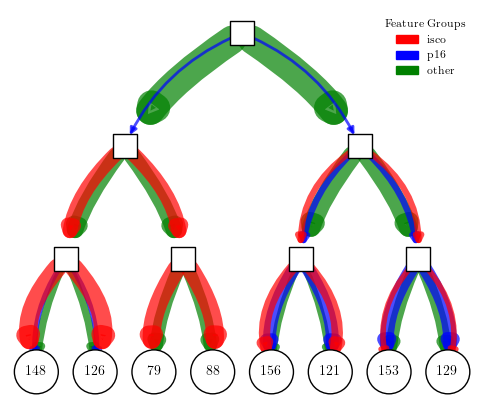

In [101]:
from matplotlib.patches import Patch

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(6,5))

for node in non_leaves:
    features = list(weights_top5[node])
    num_colors = 3
    colors = [feature_color_map[feature] for feature in features]
    edges_ = [edge for edge in edges if (edge[0]==node)]

    offset = 0.0
    for i, color in enumerate(set(colors)):
        offset += 0.1
        sum_per_group = sum([weights_top5[node][k] for k,v in feature_color_map.items() if (v==color and k in list(weights_top5[node].keys()))])
        sum_weights = sum(list(weights_top5[node].values()))
        width = (sum_per_group/sum_weights)*15
        # width = colors.count(color)
        x, y = pos[node]

        angle = i * (2 * offset) - offset
        offset_dx = offset * (num_colors - 1) * 0.5 * (-1)**i
        offset_dy = offset * (num_colors - 1) * 0.5 * (-1)**i

        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[edges_[0]], edge_color=color, width=width*1.5,
                               connectionstyle=f'arc3, rad={offset}', alpha=0.7,
                               min_source_margin=5, min_target_margin=5)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[edges_[1]], edge_color=color, width=width*1.5,
                               connectionstyle=f'arc3, rad={-offset}', alpha=0.7,
                               min_source_margin=5, min_target_margin=5)
        
nx.draw_networkx_nodes(G, pos=pos,ax=ax, nodelist=non_leaves, node_color='w', edgecolors='black', alpha = 1, node_shape='s')
nx.draw_networkx_nodes(G, pos=pos,ax=ax, nodelist=leaves, node_color='w', edgecolors='black', alpha = 1, node_size = leaf_sizes)
nx.draw_networkx_labels(G, pos=pos,ax=ax, labels=prototype_expected_value, font_size=10);

legend_elements = [Patch(color=color, label=group) for group, color in feature_group_colors.items()]
plt.legend(handles=legend_elements, title='Feature Groups', loc='upper right', frameon=False)

plt.axis('off')
plt.savefig('../reports/figures/hecat_tree_old_temp.pdf')

In [43]:
w_values = list(weights_top5.values())
top_ftrs = []
for i in range(len(w_values)):
  top_ftrs.append(list(w_values[i].keys()))

In [44]:
df.columns[top_ftrs[1]]

Index(['Entry_month_sin',
       'Reason for termination_Regular dismissal by the employer due to an unsuccessful probationary period',
       'ISCO_Customer services clerks',
       'ISCO_Legal, social and cultural professionals',
       'ISCO_Numerical and material recording clerks'],
      dtype='object')

In [45]:
sorted(list(bayes_spyct.feature_importances()), reverse=True)

[tensor(0.9000),
 tensor(0.5493),
 tensor(0.4170),
 tensor(0.3707),
 tensor(0.3626),
 tensor(0.3444),
 tensor(0.3239),
 tensor(0.3086),
 tensor(0.3082),
 tensor(0.2845),
 tensor(0.2753),
 tensor(0.2689),
 tensor(0.2601),
 tensor(0.2507),
 tensor(0.2484),
 tensor(0.2465),
 tensor(0.2451),
 tensor(0.2403),
 tensor(0.2300),
 tensor(0.2259),
 tensor(0.2192),
 tensor(0.2169),
 tensor(0.2163),
 tensor(0.2147),
 tensor(0.2143),
 tensor(0.2098),
 tensor(0.2095),
 tensor(0.2086),
 tensor(0.2054),
 tensor(0.1968),
 tensor(0.1956),
 tensor(0.1933),
 tensor(0.1907),
 tensor(0.1900),
 tensor(0.1900),
 tensor(0.1890),
 tensor(0.1845),
 tensor(0.1805),
 tensor(0.1757),
 tensor(0.1728),
 tensor(0.1726),
 tensor(0.1699),
 tensor(0.1695),
 tensor(0.1685),
 tensor(0.1684),
 tensor(0.1601),
 tensor(0.1594),
 tensor(0.1538),
 tensor(0.1535),
 tensor(0.1479),
 tensor(0.1468),
 tensor(0.1456),
 tensor(0.1432),
 tensor(0.1422),
 tensor(0.1405),
 tensor(0.1323),
 tensor(0.1305),
 tensor(0.1282),
 tensor(0.1280

In [82]:
imp_ = np.array(df.columns[list(bayes_spyct.feature_importances(k=15).keys())].tolist())

In [86]:
imp_vals = np.array(list(bayes_spyct.feature_importances(k=15).values()))

In [87]:
dict(zip(imp_, np.array(list(bayes_spyct.feature_importances(k=15).values()))))

{'Months_of_work_experience': 0.8990783095359802,
 'Reason for termination_Regular dismissal by the employer - inability due to disability': 0.5833463668823242,
 'Reason for termination_Regular dismissal by the employer due to an unsuccessful probationary period': 0.44918593764305115,
 'ISCO_Legal, social and cultural professionals': 0.3324519991874695,
 'Age': 0.32724347710609436,
 'Gender_male': 0.31822192668914795,
 'Entry_month_sin': 0.30896878242492676,
 'ISCO_Customer services clerks': 0.3071759045124054,
 'ISCO_Administrative and commercial managers': 0.2773228883743286,
 'ISCO_Numerical and material recording clerks': 0.2744142413139343,
 'ISCO_General and keyboard clerks': 0.2737194299697876,
 'P16_level_Services': 0.26643913984298706,
 'Reason for termination_Termination of a fixed-term employment contract': 0.2615724802017212,
 'ISCO_Refuse workers and other elementary workers': 0.2606739401817322,
 'Unemployment_benefits_No': 0.2597751021385193}

In [1]:
imp = {'Months_of_work_experience': 0.90,
       'Age': 0.33,
       'Entry_month': 0.31,
       'ISCO_Administrative and commercial managers': 0.28,
       'ISCO_Numerical and material recording clerks': 0.27,
       'P16_level_Services': 0.26,
       'ISCO_Refuse workers and other elementary workers': 0.25,
       'Umeployment_benefits': 0.24}

In [9]:
colour = {'Months_of_work_experience': 'green',
       'Age': 'green',
       'Entry_month': 'green',
       'ISCO_Administrative and commercial managers': 'red',
       'ISCO_Numerical and material recording clerks': 'red',
       'P16_level_Services': 'blue',
       'ISCO_Refuse workers and other elementary workers': 'red',
       'Umeployment_benefits': 'green'}

In [13]:
!pwd

/Users/viktorandonovic/IJS/phd/bayes_spyct/notebooks


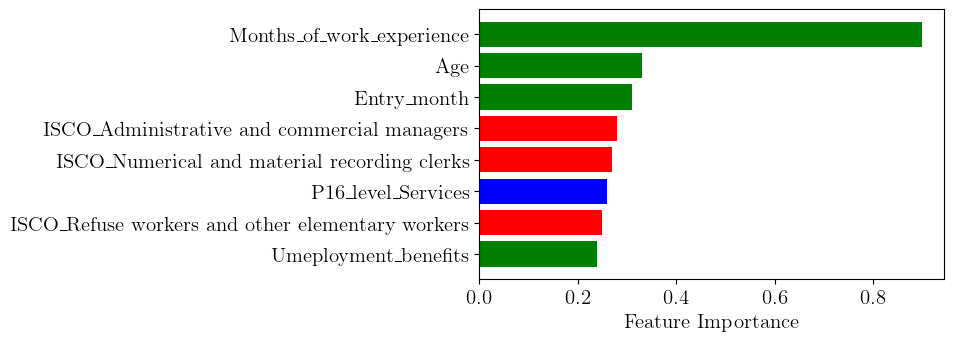

In [14]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
fig, ax = plt.subplots(figsize=(6,3.5))
# fig.set_constrained_layout(True)

ax.barh(list(imp.keys())[::-1], list(imp.values())[::-1], color=list(colour.values())[::-1])
ax.set_xlabel('Feature Importance')

plt.savefig('../../mps_conf_abstract2024/figures/feature_importance_bigfont.pdf', bbox_inches='tight')

In [74]:
imp_

array(['Months_of_work_experience',
       'Reason for termination_Regular dismissal by the employer - inability due to disability',
       'Reason for termination_Regular dismissal by the employer due to an unsuccessful probationary period',
       'Gender_male', 'ISCO_Legal, social and cultural professionals',
       'Entry_month_sin', 'ISCO_Numerical and material recording clerks',
       'ISCO_Administrative and commercial managers',
       'Unemployment_benefits_No',
       'Reason for termination_Termination of a fixed-term employment contract'],
      dtype='<U99')

In [47]:
imp_

array(['Months_of_work_experience',
       'Reason for termination_Regular dismissal by the employer - inability due to disability',
       'Reason for termination_Regular dismissal by the employer due to an unsuccessful probationary period',
       'Gender_male', 'ISCO_Legal, social and cultural professionals',
       'Entry_month_sin', 'ISCO_Numerical and material recording clerks',
       'ISCO_Administrative and commercial managers',
       'Unemployment_benefits_No',
       'Reason for termination_Termination of a fixed-term employment contract'],
      dtype='<U99')

In [48]:
from pyro.infer import Predictive
predictive = Predictive(model=bayes_spyct.root_node.right.split_model,
                    guide=bayes_spyct.root_node.right.guide,
                    num_samples=1000,
                    return_sites=(["linear.weight"]))
data = predictive(torch.ones(X_train.shape[1]))['linear.weight']

IndexError: index 96 is out of bounds for dimension 1 with size 96

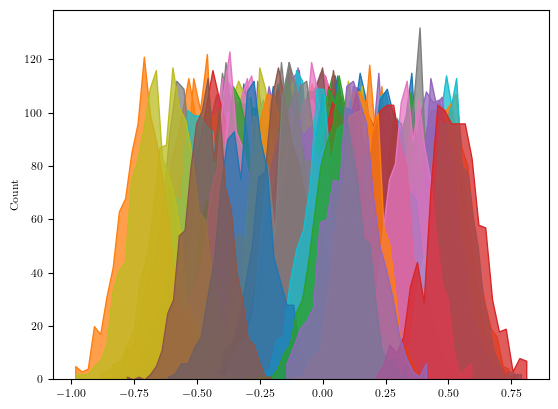

In [49]:
import seaborn as sns
for i in range(100):sns.histplot(data.reshape(data.shape[0], -1)[:,i], element='poly')

In [50]:
# import pickle
# with open('../models/vspyct_hecat_v3.pcl', 'wb') as f:
#   pickle.dump(bayes_spyct, f)

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import numpy as np

def draw_striped_edge(ax, p1, p2, stripe_colors, stripe_widths):
    """
    Draw a custom striped edge between two points.

    Args:
    - ax: The Matplotlib Axes to draw on.
    - p1, p2: Tuples representing the (x, y) coordinates of the points.
    - stripe_colors: List of colors for each stripe.
    - stripe_widths: List of widths for each stripe.
    """
    # Calculate the edge's direction
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    # dx = 3
    angle = np.arctan2(dy, dx)
    stripe_factor = 0.045
    # print(angle)

    total_width = np.sum(stripe_widths)
    factor = total_width/stripe_factor
    stripe_widths = [w / factor for w in stripe_widths]

    perp_point = np.array([-dy, dx])
    delta_start = perp_point / np.linalg.norm(perp_point) * (stripe_factor/2)

    # Draw each stripe
    current_pos = np.array(p1) - delta_start
    for color, width in zip(stripe_colors, stripe_widths):
        # print(current_pos)
        
        perpendicular = perp_point / np.linalg.norm(perp_point) * width
        # print(perpendicular)
        rect_corners = [current_pos, 
                        current_pos + perpendicular, 
                        current_pos + np.array([dx, dy]) + perpendicular, 
                        current_pos + np.array([dx, dy])]
        
        print(rect_corners)
        polygon = patches.Polygon(rect_corners, closed=True, color=color)
        ax.add_patch(polygon)

        current_pos += perp_point / np.linalg.norm(perp_point) * width#np.array([-dy, dx]) * (width / np.linalg.norm([dx, dy]))


# # Create a simple graph
# G = nx.Graph()
# G.add_nodes_from([1, 2])
# G.add_edge(1, 2)

# # Draw the graph
# pos = nx.spring_layout(G)
# fig, ax = plt.subplots()
# node_size = 300
# nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, linewidths=0)

# # Custom edge drawing
# draw_striped_edge(ax, pos[1], pos[2], ['blue', 'green', 'red'], [.06,.15,.15])#[.02, .01, .005])

# plt.axis('equal')
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([0.47817179, 0.00545705]), array([ 0.51793365, -0.00448341]), array([-0.73206635, -5.00448341]), array([-0.77182821, -4.99454295])]
[array([ 0.51793365, -0.00448341]), array([ 0.52182821, -0.00545705]), array([-0.72817179, -5.00545705]), array([-0.73206635, -5.00448341])]
[array([ 0.47817179, -0.00545705]), array([0.51793365, 0.00448341]), array([ 1.76793365, -4.99551659]), array([ 1.72817179, -5.00545705])]
[array([0.51793365, 0.00448341]), array([0.52182821, 0.00545705]), array([ 1.77182821, -4.99454295]), array([ 1.76793365, -4.99551659])]
[array([-0.77232625, -4.99720922]), array([-0.74868891, -5.00016389]), array([ -1.37368891, -10.00016389]), array([-1.39732625, -9.99720922])]
[array([-0.74868891, -5.00016389]), array([-0.72767375, -5.00279078]), array([ -1.35267375, -10.00279078]), array([ -1.37368891, -10.00016389])]
[array([-0.77232625, -5.00279078]), array([-0.74868891, -4.99983611]), array([-0.12368891, -9.99983611]), array([ -0.14732625, -10.00279078])]
[array([-0.74

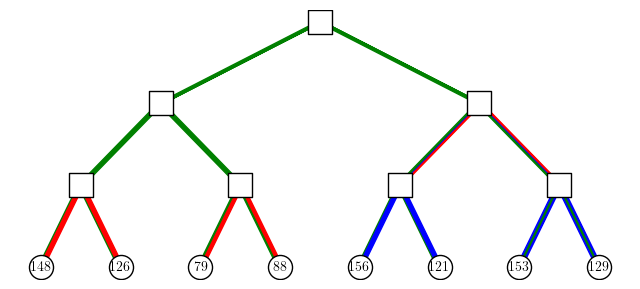

In [52]:
from matplotlib.patches import Patch

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(8,3.5))
# fig.set_constrained_layout(True)

for node in non_leaves:
    features = list(weights_top5[node])
    num_colors = 3
    colors = [feature_color_map[feature] for feature in features]
    edges_ = [edge for edge in edges if (edge[0]==node)]

    offset = 0.0
    widths = []
    for i, color in enumerate(set(colors)):
        offset += 0.1
        sum_per_group = sum([weights_top5[node][k] for k,v in feature_color_map.items() if (v==color and k in list(weights_top5[node].keys()))])
        sum_weights = sum(list(weights_top5[node].values()))
        width = (sum_per_group/sum_weights)*15
        widths.append(width)
        # width = colors.count(color)
        x, y = pos[node]

        angle = i * (2 * offset) - offset
        offset_dx = offset * (num_colors - 1) * 0.5 * (-1)**i
        offset_dy = offset * (num_colors - 1) * 0.5 * (-1)**i

    draw_striped_edge(ax, pos[edges_[0][0]], pos[edges_[0][1]], colors, widths)
    draw_striped_edge(ax, pos[edges_[1][0]], pos[edges_[1][1]], colors, widths)
        
nx.draw_networkx_nodes(G, pos=pos,ax=ax, nodelist=non_leaves, node_color='w', edgecolors='black', alpha = 1, node_shape='s')
nx.draw_networkx_nodes(G, pos=pos,ax=ax, nodelist=leaves, node_color='w', edgecolors='black', alpha = 1)#, node_size = leaf_sizes)
nx.draw_networkx_labels(G, pos=pos,ax=ax, labels=prototype_expected_value, font_size=10);

legend_elements = [Patch(color=color, label=group) for group, color in feature_group_colors.items()]
plt.legend(handles=legend_elements, title='Feature Groups', loc='center right')



# ax.plot(bs_vspyct_arr.mean(axis=0), linewidth=2.0, label='VSpyct')
# ax.plot(bs_spyct_arr.mean(axis=0), linewidth=2.0, label='Spyct')
# ax.set_xlim(0, 300)

ax.legend(frameon=False)
plt.axis('off')

plt.savefig('../reports/figures/hecat_tree.pdf')